In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
from scipy import stats

In [133]:
debugging = False
def y(n):
    return _y.loc[n,0]

def good_vs_bad(df):
    print(f"frame,n: {FRAME},{N}")
    #display(df.sort_values(by='|Vf|'))
    bins = list(range(0,30,3))
    #bins=None
    plt.rcParams['figure.figsize'] = [20, 5]
    (df.loc[df.right_direction,'|Vf|']*0.45849128846870446/N).hist(bins=bins)
    (df.loc[df.good,'|Vf|']*0.45849128846870446/N).hist(bins=bins)

def mutating_base_calcs(df):
    df['dx'] = df.x2 - df.x1 + 0.00001
    df['dy'] = df.y2 - df.y1
    df['Vf_slope'] = df.dy/df.dx
    df['|Vf|'] = np.sqrt(df.dx**2 + df.dy**2)

    df['right_direction'] = (df.y2>df.y1) & (abs(df.Vf_slope) > 3) # down and steep
    df['good'] = df['right_direction']

def analyze_lk_optical_flow_dfs(dfs):
    xs = []
    for n, df in enumerate(dfs):
        global N
        N = n + 1
        mutating_base_calcs(df)
        
        # absurd
        #df['good'] = df['good'] & (df['|Vf|'] > 2.5)
        df['good'] = df['good'] & (df['|Vf|'] < (N*30/.45))
        
        if sum(df['good']==True) == 0:
            xs += [np.nan, np.nan]
        else:
            with NP.errstate(divide='ignore',invalid='ignore'):
                df.loc[df['good'],'z'] = stats.zscore(df.loc[df['good'],'|Vf|'])
            df.loc[df['good']==False,'z'] = 100.0
            df['good'] = df['good'] & (df['z'] < 1.7)

            if len(df) != 0:
                # filter out noisy "small" flow vectors
                Vf_max_good = df[df['good']==True]['|Vf|'].max()
                df['good'] = df['good'] & (df['|Vf|'] > Vf_max_good * 0.25)
            xs.append(df.loc[df['good'],'|Vf|'].mean())
            xs.append(df.loc[df['good'],'|Vf|'].std())
        xs.append(df['dy'].mean())
        
    x = (xs[0] + xs[2]/2 + xs[4]/3)/len(dfs)
    xs.append(x)
    if debugging:
        
        for n, df in enumerate(dfs):
            N = n + 1
        
            good_vs_bad(df)
            plt.vlines(y(FRAME),0,10,colors='orange')
            plt.vlines(xs[n*2]*0.45849128846870446/N,0,10,colors='pink')
            plt.vlines(x*0.45849128846870446,0,10,colors='red')
            plt.show()
        return x
    return xs



method = analyze_lk_optical_flow_dfs

In [134]:
def frames(whichones):
    for frame in whichones:
        global FRAME
        FRAME = frame
        yield [pd.read_pickle(f'./1603934455/{frame}_{n}.pkl') for n in range(3)] 

frame,n: 0,1


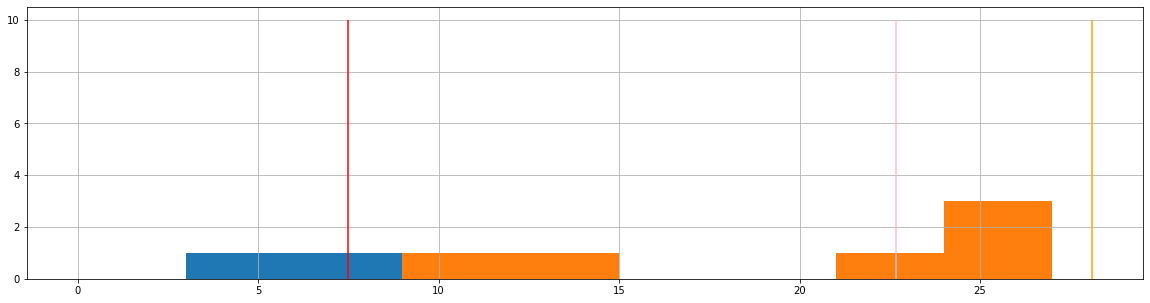

frame,n: 0,2


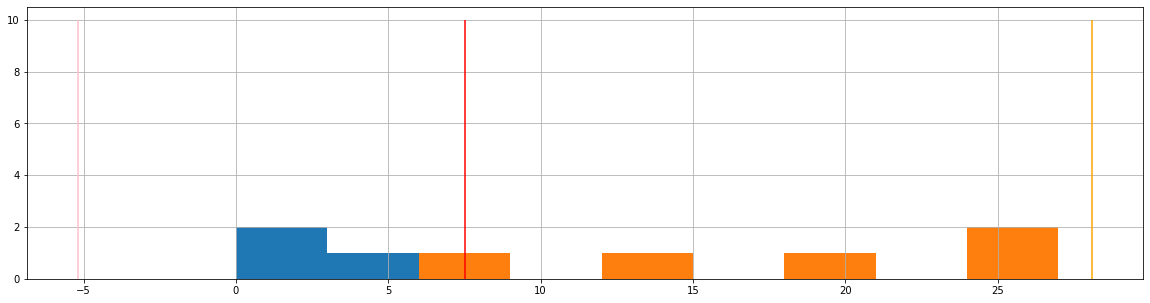

frame,n: 0,3


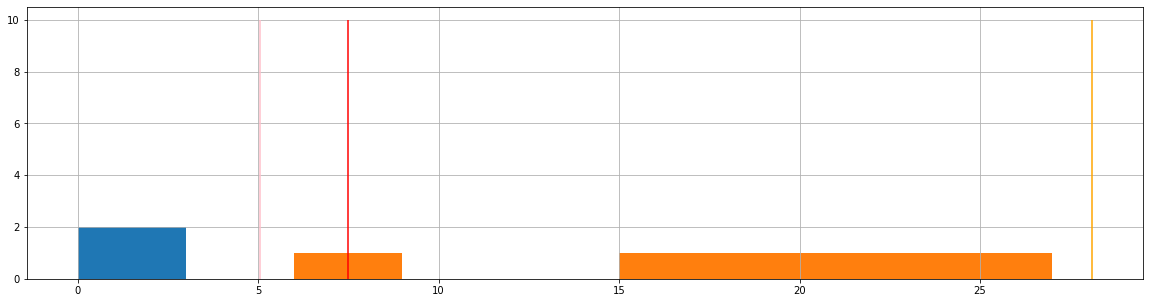

frame,n: 1000,1


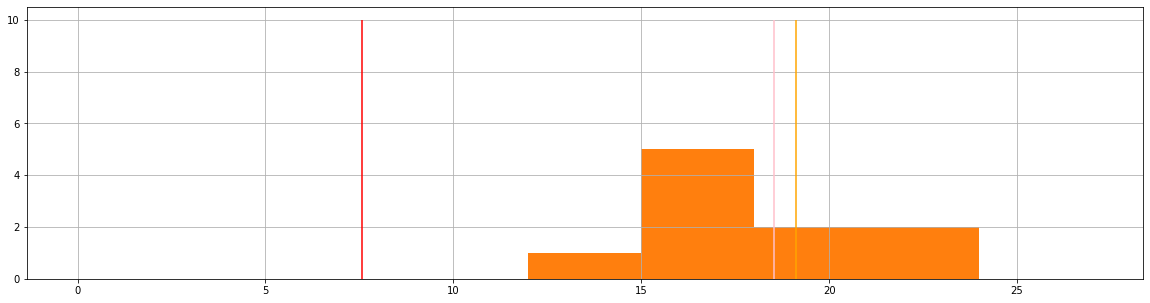

frame,n: 1000,2


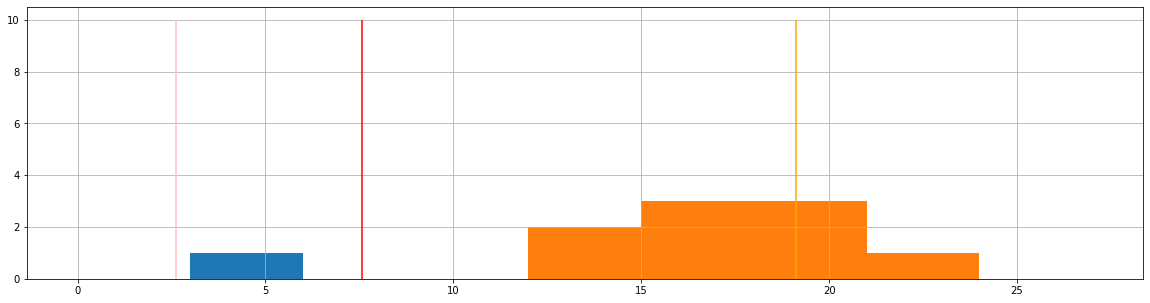

frame,n: 1000,3


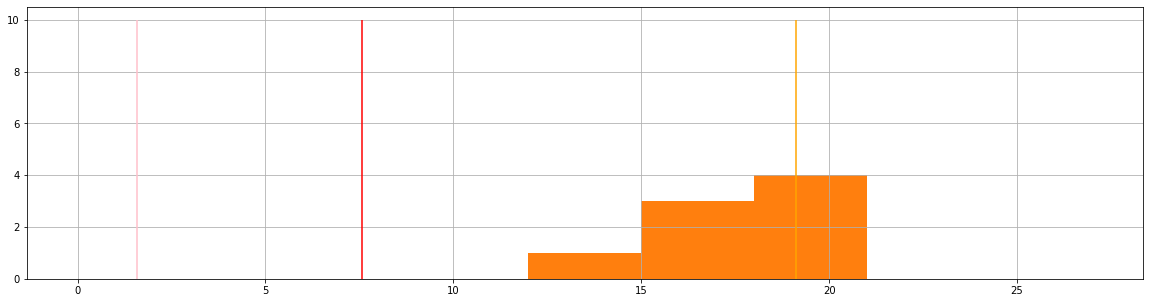

frame,n: 2000,1


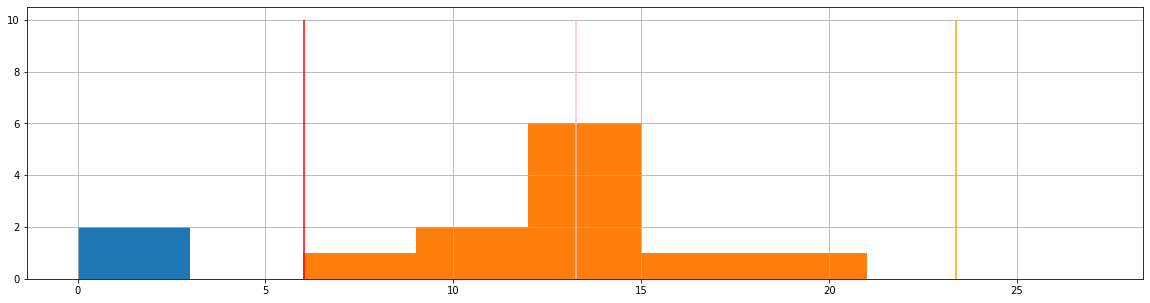

frame,n: 2000,2


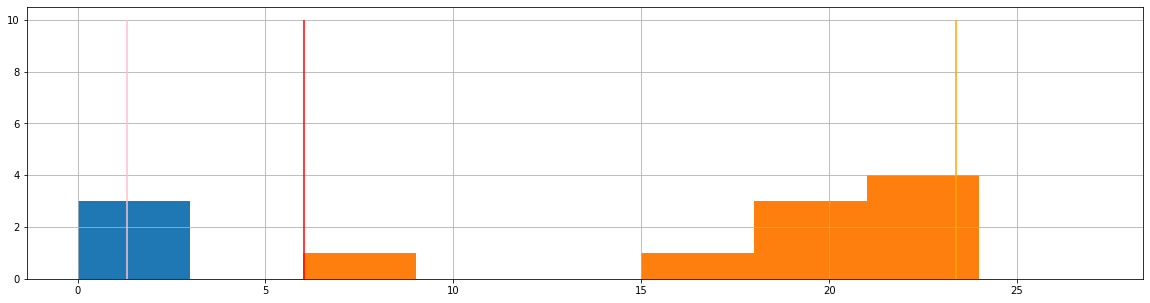

frame,n: 2000,3


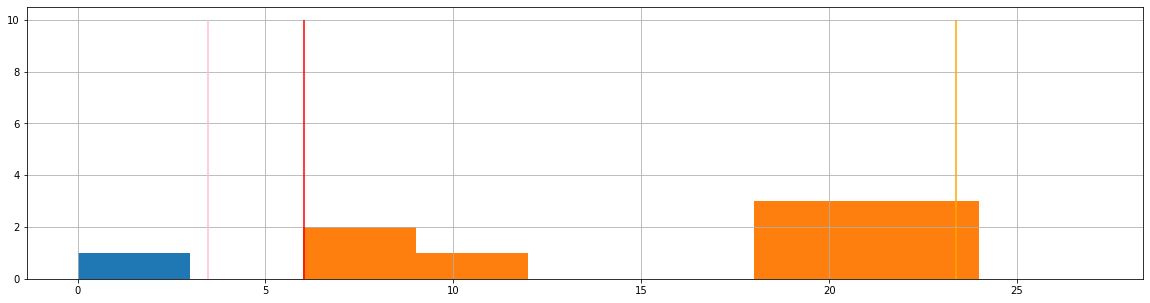

frame,n: 3000,1


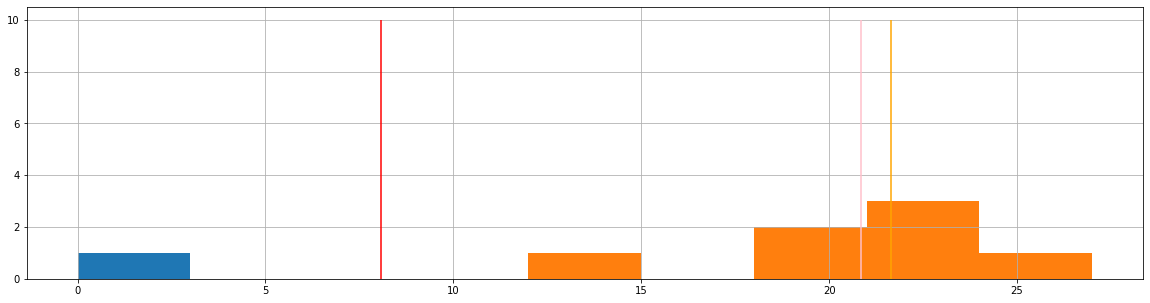

frame,n: 3000,2


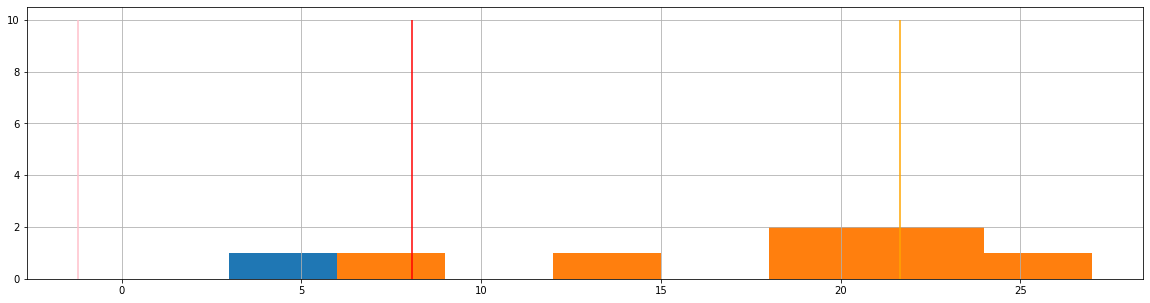

frame,n: 3000,3


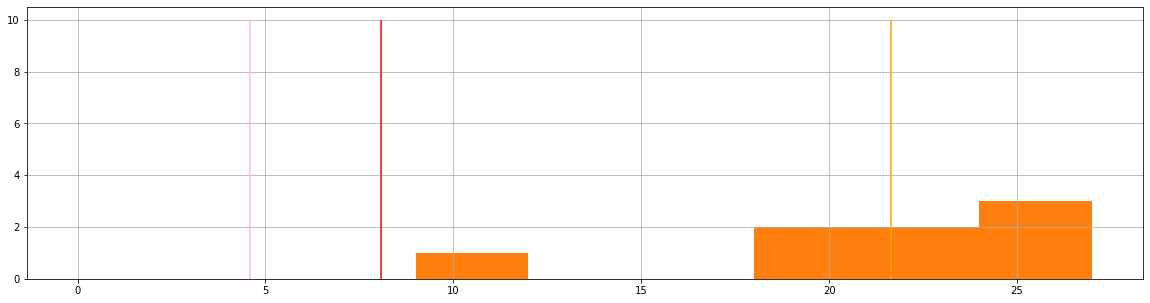

frame,n: 4000,1


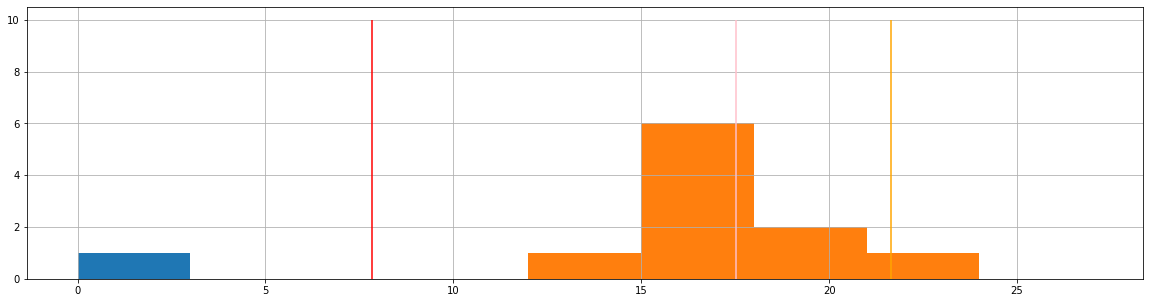

frame,n: 4000,2


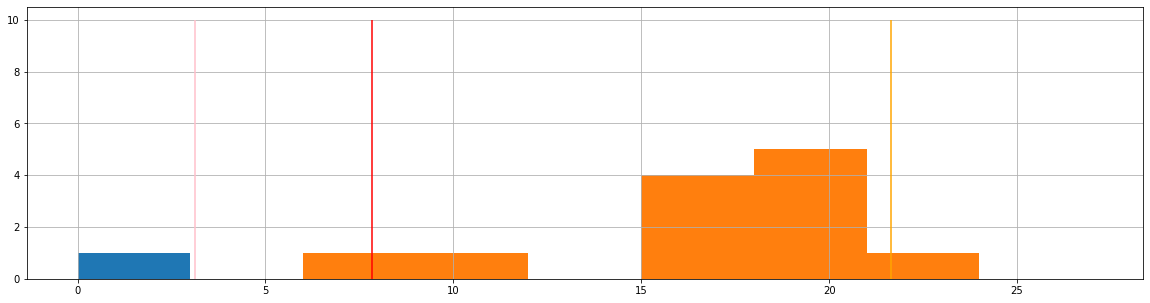

frame,n: 4000,3


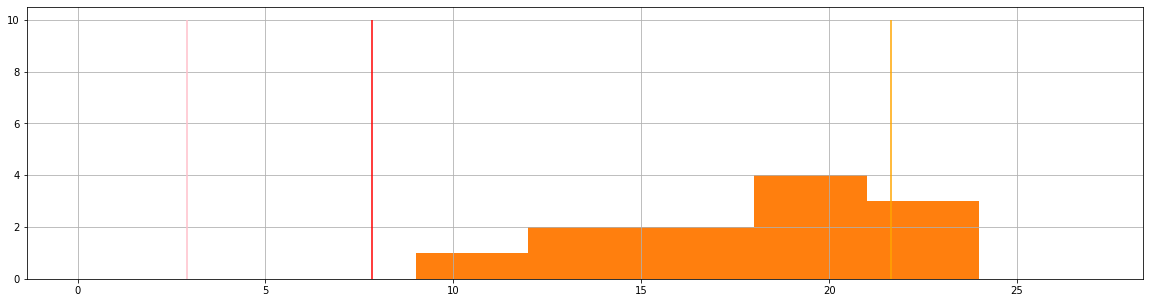

frame,n: 5000,1


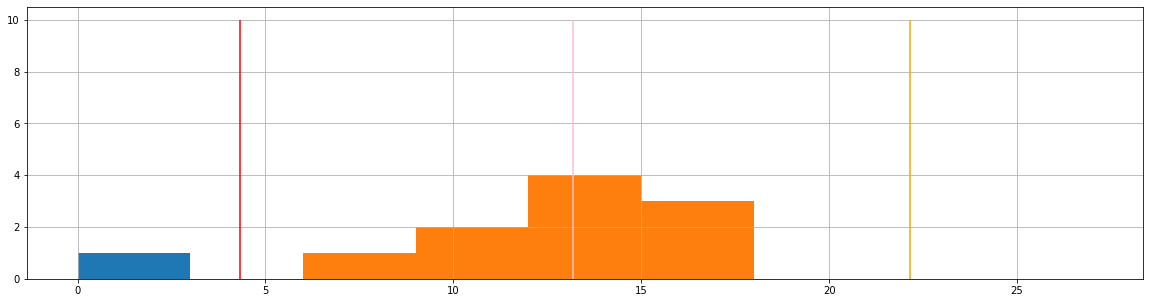

frame,n: 5000,2


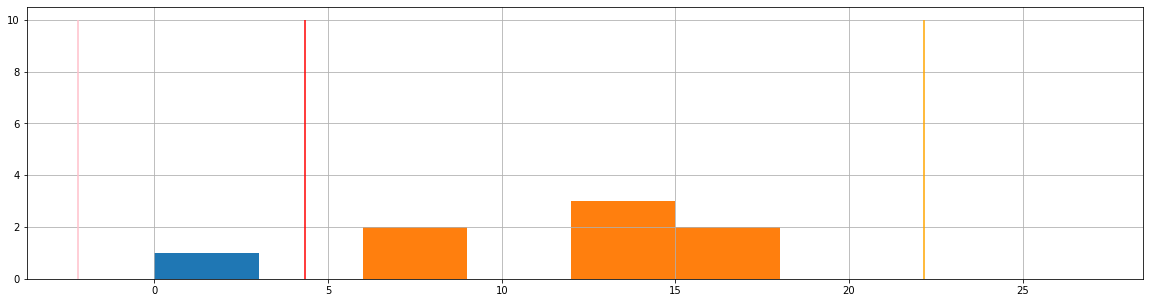

frame,n: 5000,3


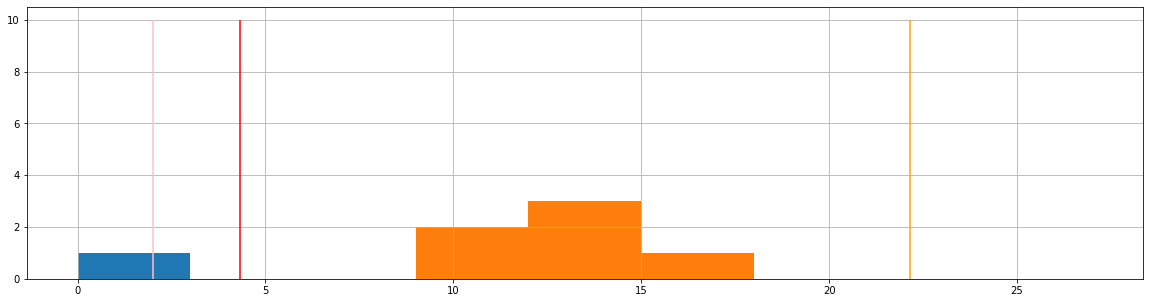

KeyboardInterrupt: 

In [131]:
debugging = True

#158,  81, 189,  83,  80, 188,  82,  77, 190, 157
centa_loc = 190
N = 0
FRAME = 0
dbg_xs = []
dbg_frames = list(range(centa_loc*100, centa_loc*100+100, 1))
dbg_frames = list(range(0, 20400, 100))

for i, dfs in enumerate(frames(dbg_frames)):
    debugging = i % 10 == 0 # inspect every 10th
    dbg_xs.append(method(dfs))


# Big run

In [ ]:
assert False

In [135]:
debugging = False

xs = []
for dfs in frames(range(20400)):
    xs.append(method(dfs))      

/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-NWwxFr2U/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/y2k/.local/share/virtualenvs/y2kspeed-N

In [ ]:
_y = pd.read_csv('../../data/train.txt', header=None)
X = pd.DataFrame(xs)
X.describe()

In [ ]:
#for unaggregated 1,2,3 frames
#X.fillna(value=0, inplace=True)
X.fillna(method='pad', inplace=True)
X['X'] = (X[0] + X[2]/2 + X[4]/3)/3 # add "theoretical average"
X.describe()

In [ ]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.0009]]) # smaller is more resistance to acceleration

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
#kf_tuned = kf.em(_y[0].values, n_iter=0, em_vars=em_vars)

In [ ]:
training_mean = _y[0].mean() # for full comparison, overly optimistic though

X['X_kf_'] = kf_tuned.smooth(X['X'].values)[0]
X['X_kf'] = X['X_kf_'] * training_mean/X['X_kf_'].mean()
X['X_scaled'] = X['X'] * training_mean/X['X'].mean()


In [ ]:
X['sq_err'] = (X['X_kf'] - _y[0])**2
err = X['sq_err'].mean()
print(f"{err:0.1f}")

In [ ]:
from sklearn.metrics import mean_squared_error

err = mean_squared_error(_y[0], X['X_kf'])

# base algorith 7.43
err

In [43]:
df = X.copy()
df = df.groupby(np.arange(len(df.index)) // 100).mean()
df.sort_values(by='sq_err', ascending=False).head(10).index.values

array([ 81, 189,  83,  82, 188,  80, 158, 190,  84,   0])